<a href="https://colab.research.google.com/github/manujism/Nilesh-Client-Simulations/blob/main/without_home.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading and preparing data...
✅ Data preparation complete.

--- Running 2,500 main simulations for 'Without Home Purchase' ---

################################################################################
###                    Detailed Monthly Log for a Single Simulation Path                    ###
################################################################################
This table shows one possible outcome, with asset values, returns, and portfolio allocation each month.
           Date    Debt_Value Debt_Return_Used    Gold_Value Gold_Return_Used  Real Estate_Value Real Estate_Return_Used  Large Cap Index_Value Large Cap Index_Return_Used  Flexi Cap Funds_Value Flexi Cap Funds_Return_Used   Total_Corpus Debt_Allocation_% Gold_Allocation_% Real Estate_Allocation_% Large Cap Index_Allocation_% Flexi Cap Funds_Allocation_%
0    2025-06-01  6,969,582.65            0.37%    504,413.40            9.30%       9,507,253.45                   0.06%           2,319,400.41          

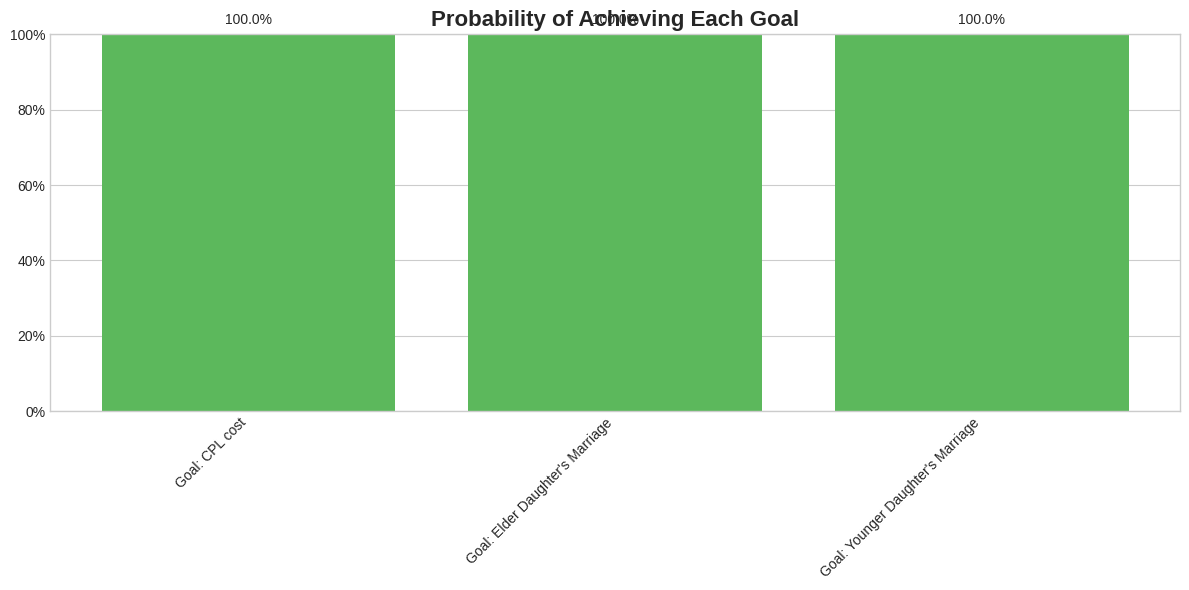

/tmp/ipython-input-2533228157.py:231: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


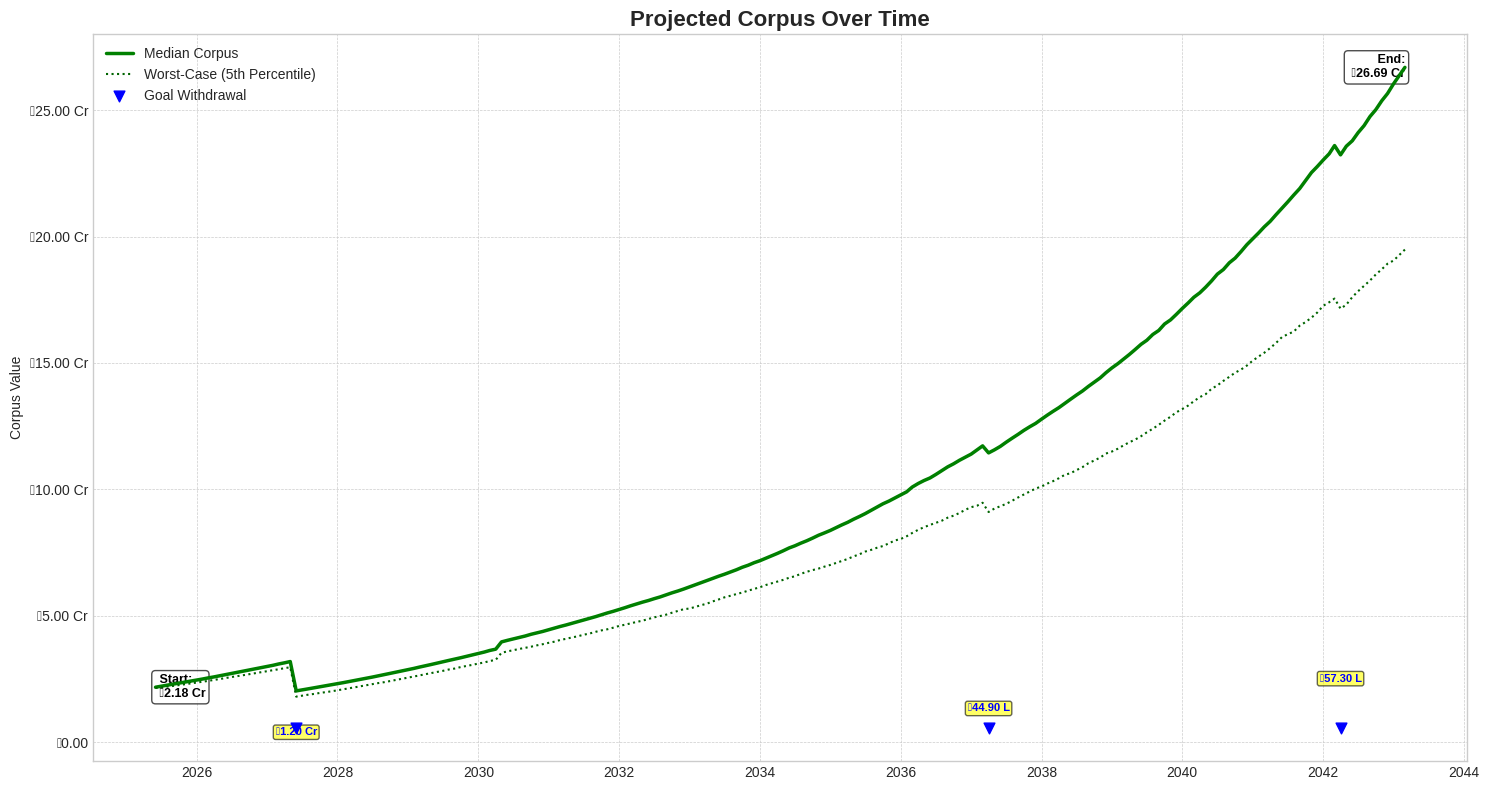

/tmp/ipython-input-2533228157.py:292: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


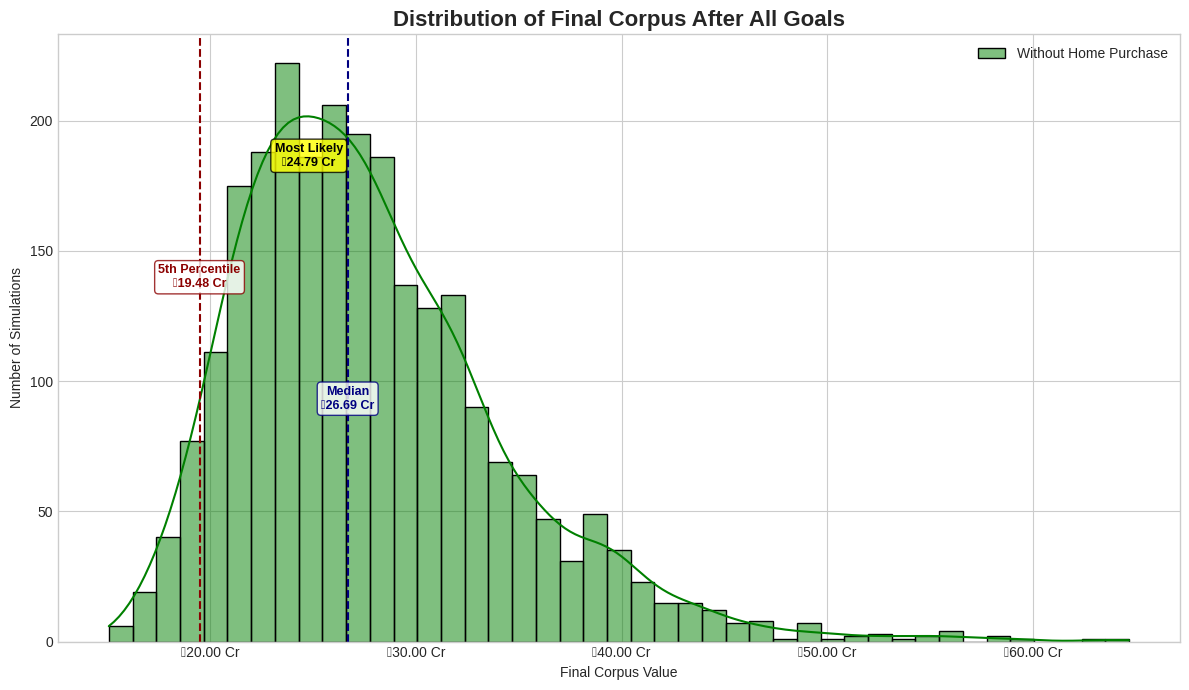


✅ All analyses complete.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from collections import Counter
import io

# --- Helper function to format numbers into the Indian numbering system (Crores & Lakhs) ---
def format_indian_currency(num):
    """Converts a number to a string in Indian Crores/Lakhs format."""
    if pd.isna(num):
        return "₹0"
    num = float(num)
    sign = "(-)" if num < 0 else ""
    num = abs(num)

    if num >= 1_00_00_000:
        return f"{sign}₹{num / 1_00_00_000:.2f} Cr"
    elif num >= 1_00_000:
        return f"{sign}₹{num / 1_00_000:.2f} L"
    else:
        return f"{sign}₹{num:,.2f}"

# --- Function to create a detailed summary DataFrame ---
def create_detailed_summary_df(raw_data, dates, goal_df):
    """Creates a detailed month-by-month summary DataFrame from raw simulation data."""
    print("\n--- [Analysis] Generating detailed monthly statistics... ---")
    summary_data = {
        'Median Corpus': np.percentile(raw_data, 50, axis=0),
        'Mean Corpus': np.mean(raw_data, axis=0),
        'Std Dev': np.std(raw_data, axis=0),
        '5th Percentile': np.percentile(raw_data, 5, axis=0),
        '95th Percentile': np.percentile(raw_data, 95, axis=0),
        'Prob. Corpus > 0': np.mean(raw_data > 0, axis=0),
        'Withdrawals': goal_df.sum(axis=1).values
    }

    summary_df = pd.DataFrame(summary_data, index=dates)
    summary_df.index.name = "Month"

    # Formatting for better readability
    currency_cols = ['Median Corpus', 'Mean Corpus', 'Std Dev', '5th Percentile', '95th Percentile', 'Withdrawals']
    for col in currency_cols:
        summary_df[col] = summary_df[col].apply(format_indian_currency)

    summary_df['Prob. Corpus > 0'] = summary_df['Prob. Corpus > 0'].apply(lambda p: f"{p:.1%}")

    return summary_df

# --- Monte Carlo Simulation Engine (Main) ---
def run_simulation(name, initial_corpus_weights, sip_weights, initial_investment, sip_schedule, goal_df, returns_df, num_simulations, dates):
    """Runs a full, multi-path simulation to get aggregate statistics."""
    print(f"\n--- Running {num_simulations:,} main simulations for '{name}' ---")
    investment_horizon_months = len(sip_schedule)
    goal_columns = goal_df.columns
    all_assets = list(set(initial_corpus_weights.keys()) | set(sip_weights.keys()))
    corpus_over_time_all_sims = np.zeros((num_simulations, investment_horizon_months))
    final_corpus_values = []
    goal_failure_counter = Counter()
    liquidity_failures = 0

    detailed_log_for_sim_1 = []

    for i in range(num_simulations):
        corpus_by_asset = {asset: initial_investment * initial_corpus_weights.get(asset, 0) for asset in all_assets}

        for month in range(investment_horizon_months):

            # ############################################################### #
            # ############## MODIFICATION FOR WITHDRAWAL LOGIC ############## #
            # ############################################################### #

            # 1. Isolate Real Estate and calculate the "liquid" (non-Real Estate) corpus.
            real_estate_corpus = corpus_by_asset.get('Real Estate', 0)
            total_corpus_before_actions = sum(corpus_by_asset.values())
            liquid_corpus = total_corpus_before_actions - real_estate_corpus
            withdrawal_amount = goal_df.iloc[month].sum()

            # 2. Check if the withdrawal can be covered by the liquid corpus.
            if withdrawal_amount > liquid_corpus:
                missed_goals = [goal for goal in goal_columns if goal_df.iloc[month][goal] > 0]
                goal_failure_counter.update(missed_goals)
                corpus_over_time_all_sims[i, month:] = 0
                liquidity_failures += 1
                break

            # 3. If withdrawal is possible, apply it ONLY to non-Real Estate assets.
            if withdrawal_amount > 0 and liquid_corpus > 0:
                reduction_factor = (liquid_corpus - withdrawal_amount) / liquid_corpus
                for asset in corpus_by_asset:
                    if asset != 'Real Estate':  # The crucial change
                        corpus_by_asset[asset] *= reduction_factor

            # ############################################################### #
            # ####################### END OF MODIFICATION ##################### #
            # ############################################################### #

            sip_this_month = sip_schedule[month]
            if sip_this_month > 0:
                for asset, weight in sip_weights.items():
                    corpus_by_asset[asset] = corpus_by_asset.get(asset, 0) + (sip_this_month * weight)

            random_returns_row = returns_df.sample(1).iloc[0]
            for asset in corpus_by_asset:
                asset_return = random_returns_row.get(asset, 0)
                corpus_by_asset[asset] *= (1 + asset_return / 100.0)

            if i == 0:
                log_entry = {'Date': dates.iloc[month].strftime('%Y-%m-%d')}

                for asset in all_assets:
                    log_entry[f'{asset}_Value'] = corpus_by_asset.get(asset, 0)
                    log_entry[f'{asset}_Return_Used'] = random_returns_row.get(asset, 0)

                log_entry['Total_Corpus'] = sum(corpus_by_asset.values())

                total_corpus_for_month = log_entry['Total_Corpus']
                if total_corpus_for_month > 0:
                    for asset in all_assets:
                        asset_value = corpus_by_asset.get(asset, 0)
                        allocation_pct = (asset_value / total_corpus_for_month) * 100
                        log_entry[f'{asset}_Allocation_%'] = allocation_pct
                else:
                    for asset in all_assets:
                        log_entry[f'{asset}_Allocation_%'] = 0.0

                detailed_log_for_sim_1.append(log_entry)

            corpus_over_time_all_sims[i, month] = sum(corpus_by_asset.values())

        final_total_corpus = sum(corpus_by_asset.values())
        final_corpus_values.append(final_total_corpus if final_total_corpus >= 0 else 0)

    print("\n" + "#"*80)
    print("###" + " "*20 + "Detailed Monthly Log for a Single Simulation Path" + " "*20 + "###")
    print("#"*80)
    print("This table shows one possible outcome, with asset values, returns, and portfolio allocation each month.")

    if detailed_log_for_sim_1:
        detailed_df = pd.DataFrame(detailed_log_for_sim_1)
        display_df = detailed_df.copy()

        for col in display_df.columns:
            if '_Return_Used' in col or '_Allocation_%' in col:
                display_df[col] = display_df[col].apply(lambda x: f'{x:.2f}%')

        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', 2000)
        pd.options.display.float_format = '{:,.2f}'.format

        print(display_df)
    else:
        print("No data logged for the detailed simulation view.")
    print("\n")

    prob_all_goals = 1 - (liquidity_failures / num_simulations)
    goal_success_prob = {goal: 1 - (goal_failure_counter.get(goal, 0) / num_simulations) for goal in goal_columns if goal_df[goal].sum() > 0}

    return {
        'name': name, 'prob_all_goals': prob_all_goals, 'median_corpus': np.median(final_corpus_values),
        '5th_percentile_corpus': np.percentile(final_corpus_values, 5), 'final_corpus_values': final_corpus_values,
        'goal_success_prob': goal_success_prob, 'corpus_over_time_median': np.percentile(corpus_over_time_all_sims, 50, axis=0),
        'corpus_over_time_p5': np.percentile(corpus_over_time_all_sims, 5, axis=0),
        'raw_corpus_data': corpus_over_time_all_sims
    }

# --- Visualization Functions ---
def plot_goal_probabilities(results):
    """Generates a bar chart of individual goal success probabilities."""
    plt.style.use('seaborn-v0_8-whitegrid')
    goal_probs = results['goal_success_prob']
    if not goal_probs:
        print("No goals with non-zero amounts to plot.")
        return
    goals = list(goal_probs.keys())
    probabilities = list(goal_probs.values())
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(goals, probabilities, color='#5cb85c')
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
    ax.set_title('Probability of Achieving Each Goal', fontsize=16, weight='bold')
    plt.xticks(rotation=45, ha='right')
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.02, f'{yval:.1%}', ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

def plot_corpus_projections(results, goal_df, dates):
    """Generates a line chart of projected corpus value over time with annotations."""
    plt.figure(figsize=(15, 8))
    median_line = results['corpus_over_time_median']
    p5_line = results['corpus_over_time_p5']

    plt.plot(dates, median_line, label="Median Corpus", color='green', linewidth=2.5, zorder=10)
    plt.plot(dates, p5_line, label="Worst-Case (5th Percentile)", color='darkgreen', linestyle=':', zorder=10)

    # Add annotations for start and end points of the median line
    plt.text(dates.iloc[0], median_line[0], f' Start:\n {format_indian_currency(median_line[0])}',
             ha='left', va='center', fontsize=9, color='black', weight='bold',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))
    plt.text(dates.iloc[-1], median_line[-1], f' End:\n {format_indian_currency(median_line[-1])}',
             ha='right', va='center', fontsize=9, color='black', weight='bold',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7))

    # Add annotations for withdrawals
    withdrawals = goal_df.sum(axis=1)
    withdrawal_dates = dates[withdrawals > 0]
    withdrawal_amounts = withdrawals[withdrawals > 0]

    # Get y-axis limits to place markers at the bottom of the chart
    ymin, _ = plt.gca().get_ylim()
    # Plot markers at the bottom, not at y=0, and use clip_on=False
    plt.scatter(withdrawal_dates, [ymin] * len(withdrawal_dates), marker='v', color='blue', s=60, zorder=5, label='Goal Withdrawal', clip_on=False)

    # Get median corpus values at withdrawal dates to position labels intelligently
    median_values_at_withdrawal = np.interp(withdrawal_dates.astype(np.int64), dates.astype(np.int64), median_line)

    for date, amount, y_pos in zip(withdrawal_dates, withdrawal_amounts, median_values_at_withdrawal):
        plt.text(date, y_pos * 0.1, f'{format_indian_currency(amount)}', # Position label at 10% of median height
                 ha='center', va='bottom', fontsize=8, color='blue', weight='bold',
                 bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.6))

    plt.title('Projected Corpus Over Time', fontsize=16, weight='bold')
    plt.ylabel('Corpus Value')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: format_indian_currency(y)))
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

def plot_final_corpus_distribution(results):
    """Generates a histogram of the final corpus distribution with annotations."""
    plt.figure(figsize=(12, 7))

    # Check if there's any variation in the data before plotting
    final_values = results['final_corpus_values']
    if np.std(final_values) == 0:
        print("\n⚠️  [Plotting Warning] Could not generate final corpus distribution plot.")
        print("    Reason: All simulation results were identical (e.g., all ended at ₹0).")
        # Create a simple message plot instead of an empty one.
        plt.text(0.5, 0.5, 'Distribution plot not available\ndue to no variance in outcomes.',
                 ha='center', va='center', fontsize=12, color='red')
        plt.title('Distribution of Final Corpus After All Goals', fontsize=16, weight='bold')
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.show()
        return # Exit the function early

    # CHANGE: Use histplot to show counts, but keep the kde overlay for a smooth curve
    ax = sns.histplot(data=final_values, kde=True, fill=True, color='green', label=results['name'])

    # Get key statistical values
    median_val = results['median_corpus']
    p5_val = results['5th_percentile_corpus']

    ymin, ymax = ax.get_ylim()

    # The logic to find the mode (peak) still works by inspecting the overlaid KDE line
    if ax.lines:
        line = ax.lines[0]
        x, y = line.get_data()
        peak_index = np.argmax(y)
        mode_val = x[peak_index]

        # Annotation for Mode (Most Likely Outcome)
        # Positioned relative to the new y-axis (counts)
        plt.text(mode_val, ymax * 0.8, f'Most Likely\n{format_indian_currency(mode_val)}',
                 ha='center', va='center', fontsize=9, color='black', weight='bold',
                 bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.8))

    # Annotation for 5th Percentile (positioning is relative to ymax, which is now count)
    plt.axvline(p5_val, color='darkred', linestyle='--', linewidth=1.5)
    plt.text(p5_val, ymax * 0.6, f'5th Percentile\n{format_indian_currency(p5_val)}',
             ha='center', va='center', fontsize=9, color='darkred', weight='bold',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='darkred', alpha=0.8))

    # Annotation for Median (positioning is relative to ymax, which is now count)
    plt.axvline(median_val, color='navy', linestyle='--', linewidth=1.5)
    plt.text(median_val, ymax * 0.4, f'Median\n{format_indian_currency(median_val)}',
             ha='center', va='center', fontsize=9, color='navy', weight='bold',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='navy', alpha=0.8))

    plt.title('Distribution of Final Corpus After All Goals', fontsize=16, weight='bold')
    plt.xlabel('Final Corpus Value')
    # CHANGE: Set the y-axis label to be more descriptive
    plt.ylabel('Number of Simulations')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: format_indian_currency(x)))
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Main Execution Block ---
def main():
    # NOTE: You will need to create dummy Excel files or replace these with your actual files.
    CLIENT_DATA_FILE = 'Nilesh M. Concise Data Without Home.xlsx'
    RETURNS_FILE = 'Monthly Returns - Pune Real Estate Included.xlsx'
    CLIENT_DATA_SHEET = 'Without Home Purchase'
    RETURNS_SHEET = 'Sheet2'

    try:
        print("Loading and preparing data...")
        client_data_df = pd.read_excel(CLIENT_DATA_FILE, sheet_name=CLIENT_DATA_SHEET)
        returns_df = pd.read_excel(RETURNS_FILE, sheet_name=RETURNS_SHEET)

        returns_df.columns = returns_df.columns.str.strip()
        if 'Unnamed: 0' in returns_df.columns:
            returns_df = returns_df.drop(returns_df.columns[0], axis=1)
        master_asset_list = returns_df.columns.tolist()

        returns_df[master_asset_list] = returns_df[master_asset_list].apply(pd.to_numeric, errors='coerce')
        returns_df.dropna(subset=master_asset_list, inplace=True)

        client_data_df['Month'] = pd.to_datetime(client_data_df['Month'])
        dates = client_data_df['Month']
        sip_schedule = pd.to_numeric(client_data_df['Total Investment'], errors='coerce').fillna(0).values
        goal_cols = [col for col in client_data_df.columns if 'Goal:' in col]
        goal_df = client_data_df[goal_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

        print("✅ Data preparation complete.")

        initial_investment = 21428380
        num_simulations = 2500
        initial_corpus_weights = {
            'Real Estate': 0.4434, 'Debt': 0.3221,
            'Flexi Cap Funds': 0.10745, 'Large Cap Index': 0.10745,
            'Gold': 0.0196
        }
        sip_weights = {
            'Flexi Cap Funds': 0.30, 'Large Cap Index': 0.30,
            'Debt': 0.20, 'Gold': 0.20
        }

        results = run_simulation(
            "Without Home Purchase", initial_corpus_weights, sip_weights, initial_investment,
            sip_schedule, goal_df, returns_df, num_simulations, dates
        )

        print("\n\n" + "#"*80)
        print("###" + " "*27 + "SIMULATION ANALYSIS" + " "*28 + "###")
        print("#"*80)

        print("\n" + "="*65); print(" " * 20 + "1. Key Results"); print("="*65)
        print(f"Overall Success Probability: {results['prob_all_goals']:.1%}")
        print(f"Median Final Corpus: {format_indian_currency(results['median_corpus'])}")
        print(f"Worst-Case Corpus (5th %ile): {format_indian_currency(results['5th_percentile_corpus'])}")

        print("\n" + "="*65); print(" " * 15 + "2. Individual Goal Success Probability"); print("="*65)
        goal_probs = results['goal_success_prob']
        if goal_probs:
            for goal, prob in goal_probs.items():
                print(f"{goal}: {prob:.1%}")
        else:
            print("No specific goals found in the data.")

        print("\n" + "="*65); print(" " * 17 + "3. Detailed Monthly Projections"); print("="*65)

        detailed_summary_df = create_detailed_summary_df(
            results['raw_corpus_data'], dates, goal_df
        )

        print("\nThis table shows the month-by-month projection of your portfolio's value,")
        print("including statistical measures to show the range of possible outcomes.")

        print("\n--- Summary Statistics (First 12 Months) ---")
        print(detailed_summary_df.head(12))

        print("\n--- Summary Statistics (Last 12 Months) ---")
        print(detailed_summary_df.tail(12))

        print("\n\n" + "#"*80)
        print("###" + " "*30 + "GENERATING VISUALS" + " "*30 + "###")
        print("#"*80)
        plot_goal_probabilities(results)
        plot_corpus_projections(results, goal_df, dates)
        plot_final_corpus_distribution(results)
        print("\n✅ All analyses complete.")

    except FileNotFoundError as e:
        print(f"\n❌ ERROR: Data file not found. Make sure the file '{e.filename}' is in the correct directory.")
    except KeyError as e:
        print(f"\n❌ ERROR: A required column, asset, or sheet name was not found: {e}. Check your file and sheet names.")
    except Exception as e:
        print(f"\n❌ An unexpected error occurred: {e}")

if __name__ == '__main__':
    main()